## 1. Import Libraries

In [12]:
import os 
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

## 1. A Glance

### 1.1. Convert to Waveform

In [13]:
CAPUCHIN_FILE = "/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC114131-0.wav"
NOT_CAPUCHIN_FILE = "/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/Crickets-chirping-0.wav"

In [14]:
def load_wav_16k_mono(filename):
    
    # file_contents is string format of the audio
    file_contents = tf.io.read_file(filename)
    
    # Decode this string
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    
    wav = tf.squeeze(wav, axis = -1)
    # The herts of audio
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    
    return wav

In [15]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
not_wave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

### 1.2. Visualize waves

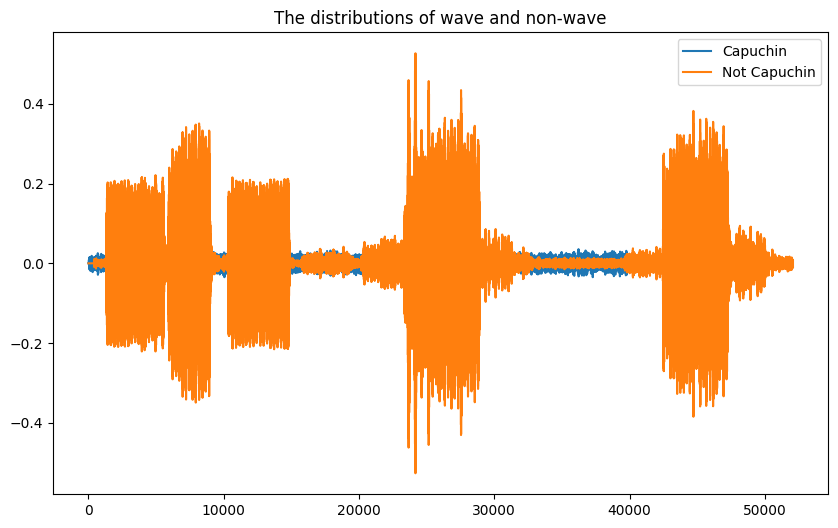

In [16]:
plt.figure(figsize = (10,6))
plt.title("The distributions of wave and non-wave")

plt.plot(wave, label='Capuchin')
plt.plot(not_wave, label='Not Capuchin')

plt.legend()
plt.show()

## 2. Create Dataset

### 2.1. Define Constants

In [17]:
POS = "/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips"
NEG = "/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips"

### 2.2. Create TF Datasets

In [18]:
pos_dataset = tf.data.Dataset.list_files(POS+'/*.wav')
neg_dataset = tf.data.Dataset.list_files(NEG+'/*.wav')

### 2.3. Add Labels

<h5>    
Pos = 1<br><br>
Neg = 0 
</h5>

In [19]:
print("Size of Positive: ", len(pos_dataset))
print("Size of Negative: ", len(neg_dataset))

Size of Positive:  217
Size of Negative:  593


In [20]:
positives = tf.data.Dataset.zip((pos_dataset, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos_dataset)))))
negatives = tf.data.Dataset.zip((neg_dataset, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg_dataset)))))
data = positives.concatenate(negatives)

In [21]:
# One value of data
data.as_numpy_iterator().next()

# it involves label too.

(b'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC520626-0.wav',
 1.0)

## 3. Determine Average Length of a Capuchin Call

### 3.1. Calculate Wave Cycle Length

In [22]:
lengths = []
for file in os.listdir(POS):
    tensor_wave = load_wav_16k_mono(os.path.join(POS, file))
    lengths.append(len(tensor_wave))

### 3.2. Calculate Mean, Min and Max

In [23]:
print("Mean:", tf.math.reduce_mean(lengths))
print("Min:", tf.math.reduce_min(lengths))
print("Max:", tf.math.reduce_max(lengths))

print("\nThe value has max seconds:", tf.math.reduce_max(lengths)/16000)
print("The value has min seconds:", tf.math.reduce_min(lengths)/16000)

Mean: tf.Tensor(54156, shape=(), dtype=int32)
Min: tf.Tensor(32000, shape=(), dtype=int32)
Max: tf.Tensor(80000, shape=(), dtype=int32)

The value has max seconds: tf.Tensor(5.0, shape=(), dtype=float64)
The value has min seconds: tf.Tensor(2.0, shape=(), dtype=float64)


## 4. Build Preprocessing Function to Convert to Spectrogram (STFT)

### 4.1. Build Preprocessing Function (STFT)

In [24]:
def preprocess(file_path, label):
    # Convert to waveform
    wav = load_wav_16k_mono(file_path)
    
    # Get 48k sample. It is nearly an average. 
    wav = wav[:48000]
    
    # Add padding for values that are less than 48k
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    
    # Perform STFT
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis = 2)
    
    return spectrogram, label

### 4.2. Test Out the Preprocessing Function

In [25]:
positive_filepath, positive_label = positives.shuffle(buffer_size =1000).as_numpy_iterator().next()
negative_filepath, negative_label = negatives.shuffle(buffer_size =1000).as_numpy_iterator().next()

In [26]:
positive_spectrogram, positive_label = preprocess(positive_filepath, positive_label)
negative_spectrogram, negative_label = preprocess(negative_filepath, negative_label)

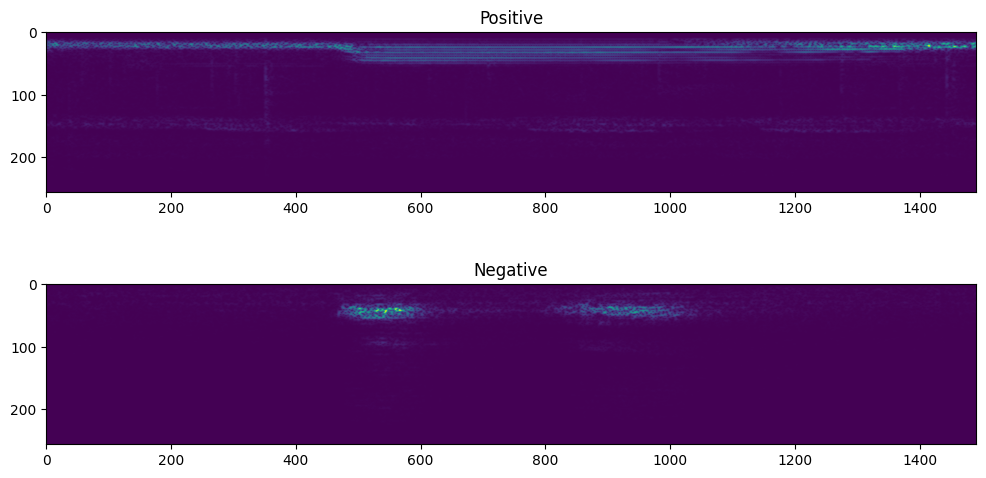

In [27]:
fig, ax = plt.subplots(2,1, figsize = (12, 6))

ax[0].imshow(tf.transpose(positive_spectrogram)[0])
ax[0].set_title("Positive")

ax[1].imshow(tf.transpose(negative_spectrogram)[0])
ax[1].set_title("Negative")

fig.show()

## 5. Create Training and Testing Partitions

### 5.1. Create a Tensorflow Data Pipeline

In [28]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size = 1000)
data = data.batch(5)
data = data.prefetch(8)

### 5.2. Split into Training and Testing Partitions

In [29]:
print("70% of data batches:", len(data)*.7)
print("30% of data batches:", len(data)*.3)

70% of data batches: 113.39999999999999
30% of data batches: 48.6


In [30]:
# we can split 113 batches of whole data batches for train part 
train = data.take(113)
test = data.skip(113).take(48)

### 5.3. Test One Batch

In [31]:
samples, labels = train.as_numpy_iterator().next()

print("Shape of Label for a batch:", labels.shape)
print("Shape of Values for a batch:", samples.shape)

Shape of Label for a batch: (5,)
Shape of Values for a batch: (5, 1491, 257, 1)


## 6. Build Deep Learning Model

### 6.1. Lead Tensorflow Dependencies

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout

### 6.2. Build Sequential Model, Compile and View Summary

In [33]:
# I can't build a huge model due to my hardware restrictions. So I will able to get low score. 
# You try to change model as do as you can for better results and knowledges

model = Sequential()
model.add(Conv2D(16, (3,3), activation = 'relu', input_shape=(1491, 257, 1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(16, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [34]:
model.compile(optimizer='Adam', loss='BinaryCrossentropy', 
              metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 744, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 371, 62, 16)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 371, 62, 16)       0         
                                                                 
 flatten (Flatten)           (None, 368032)            0

### 6.3. Fit Model, View Loss and KPI Plots

In [ ]:
hist = model.fit(train, epochs=3, validation_data = test)

Epoch 1/3
 12/113 [==>...........................] - ETA: 1:57 - loss: 1.6785 - recall: 0.8400 - precision: 0.7241

In [ ]:
fig, axes = plt.subplots(2,2, figsize = (16,12))

axes[0][0].plot(hist.history['loss'], 'r', label = "Loss")
axes[0][0].plot(hist.history['val_loss'], 'b', label = "Val Loss")
axes[0][0].set_title("Loss")
axes[0][0].legend()

axes[0][1].plot(hist.history['precision_1'], 'r', label = "Precision")
axes[0][1].plot(hist.history['val_precision_1'], 'b', label = "Val Precision")
axes[0][1].set_title("Precision")
axes[0][1].legend()

axes[1][0].plot(hist.history['recall_1'], 'r', label = "Recall")
axes[1][0].plot(hist.history['val_recall_1'], 'b', label = "Val Recall")
axes[1][0].set_title("Recall")
axes[1][0].legend()

axes[1, 1].axis('off')
plt.tight_layout()

plt.show()

## 7. Make a Prediction On a Single Clip

### 7.1. Get One Batch and Make a Prediction

In [ ]:
X_test, y_test = test.shuffle(1000).as_numpy_iterator().next()

In [ ]:
print("X test shape:", X_test.shape)
print("y test shape:", y_test.shape)

In [ ]:
yhat = model.predict(X_test)

### 7.2. Convert Logits to Classes

In [ ]:
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

In [ ]:
print("Actual Values: ", y_test)
print("Predictions:", yhat)

## 8. Build Forest Parsing Functions

### 8.1. Load up MP3s

In [ ]:
def load_mp3_16k_mono(filename):
    # Convert to 16k mono from mp3 file
    res = tfio.audio.AudioIOTensor(filename)
    
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis = 1) / 2
    
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype= tf.int64)
    
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = "/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings/recording_00.mp3"

In [ ]:
wave = load_mp3_16k_mono(mp3)

In [ ]:
wave

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wave, wave, sequence_length=48000,
                                                           sequence_stride=48000, batch_size=64)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

print("The shape of a batch: ", samples.shape)

### 8.2. Build Function to Convert Clips into Windowed Spectrograms

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wave = tf.concat([zero_padding, sample], 0)
    
    spectrogram = tf.signal.stft(wave, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9. Make Predictions

### 9.1. Loop over all recordings and make predictions

In [ ]:
FOREST_FOLDER_PATH = "/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings"

In [ ]:
# I am getting 5 sample forest files due to lack of my memory.

results = {}
for file in os.listdir(FOREST_FOLDER_PATH)[:5]:
    FILEPATH = os.path.join(FOREST_FOLDER_PATH, file)
    
    wave = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wave, wave, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

### 9.2. Convert Predictions into Classes

In [ ]:
# The threshold value is up to you.

class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]

### 9.3. Group Consecutive Detections

In [ ]:
from itertools import groupby

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()

postprocessed

## 10. Export Results

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    write = csv.writer(f, delimiter=',')
    write.writerow(['recording', 'capuchin_calls'])
    
    for key, value in postprocessed.items():
        write.writerow([key,value])